In [2]:
# conventional libraries
import os
import calendar
import pandas as pd
import numpy as np

# data visualizations
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import seaborn as sns
import matplotlib.pyplot as plt

# algorithm
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("df_cleaned.csv")
#from https://www.kaggle.com/abdulmeral/rfm-analysis-for-successful-customer-segmentation

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,QuantityCanceled,...,Week,Year_Month,Hour,Day,is_cancelled,weekday_nr,weekday,Quarter,Date,RefundFlg
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False


In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
data_apriori = df[df['Country']=='United Kingdom']
data_apriori.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,QuantityCanceled,...,Week,Year_Month,Hour,Day,is_cancelled,weekday_nr,weekday,Quarter,Date,RefundFlg
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,0,...,48,2010-12,8,1,0,3,Wednesday,Q3,2010-12-01 00:00:00,False


In [5]:
# Which Product and Their Count 
data_apr = data_apriori.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
data_apr.head()

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,toadstool bedside light,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
basket_new = data_apr.applymap(lambda x: 1 if x>0 else 0)
basket_new.head()

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,toadstool bedside light,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
basket_new.iloc[0].value_counts()

0    3996
1       7
Name: 536365, dtype: int64

In [8]:
itemsets = apriori(basket_new, min_support=0.02, use_colnames=True)

In [9]:
itemsets.sort_values('support',ascending=False).head()

,support,itemsets
281,0.120513,(white hanging heart t-light holder)
110,0.107860,(jumbo bag red retrospot)
205,0.093924,(regency cakestand 3 tier)
166,0.088796,(party bunting)
136,0.077592,(lunch bag red retrospot)


In [10]:
rules = association_rules(itemsets, metric="lift", min_threshold=1)
rules.shape

(226, 9)

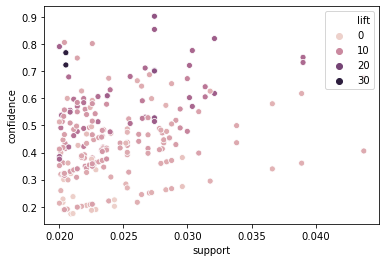

In [11]:
sns.scatterplot(x='support', y='confidence', hue='lift', data=rules)
plt.show()

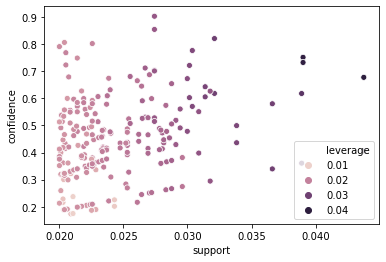

In [12]:
sns.scatterplot(x='support', y='confidence', hue='leverage', data=rules)
plt.show()

In [22]:
rules.sort_values(['support', 'lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
66,(jumbo bag pink polkadot),(jumbo bag red retrospot),0.064604,0.107860,0.043757,0.677308,6.279538,0.036789,2.764681
67,(jumbo bag red retrospot),(jumbo bag pink polkadot),0.107860,0.064604,0.043757,0.405685,6.279538,0.036789,1.573905
36,(green regency teacup and saucer),(roses regency teacup and saucer ),0.051951,0.053289,0.039019,0.751073,14.094403,0.036251,3.803168
37,(roses regency teacup and saucer ),(green regency teacup and saucer),0.053289,0.051951,0.039019,0.732218,14.094403,0.036251,3.540371
92,(jumbo bag red retrospot),(jumbo storage bag suki),0.107860,0.062988,0.038907,0.360724,5.726885,0.032114,1.465739
93,(jumbo storage bag suki),(jumbo bag red retrospot),0.062988,0.107860,0.038907,0.617699,5.726885,0.032114,2.333608
88,(jumbo shopper vintage red paisley),(jumbo bag red retrospot),0.063155,0.107860,0.036622,0.579876,5.376219,0.029810,2.123519
89,(jumbo bag red retrospot),(jumbo shopper vintage red paisley),0.107860,0.063155,0.036622,0.339535,5.376219,0.029810,1.418463
118,(lunch bag black skull.),(lunch bag red retrospot),0.067781,0.077592,0.033835,0.499178,6.433367,0.028576,1.841787
119,(lunch bag red retrospot),(lunch bag black skull.),0.077592,0.067781,0.033835,0.436063,6.433367,0.028576,1.653055


In [14]:
from mlxtend.frequent_patterns import fpgrowth
rule_fp = fpgrowth(basket_new, min_support=0.02, use_colnames=True)
rule_fp

,support,itemsets
0,0.120513,(white hanging heart t-light holder)
1,0.024972,(knitted union flag hot water bottle)
2,0.022910,(red woolly hottie white heart.)
3,0.026533,(hand warmer union jack)
4,0.076421,(assorted colour bird ornament)
...,...,...
398,0.022129,"(jumbo bag alphabet, jumbo bag red retrospot)"
399,0.025195,"(spotty bunting, party bunting)"
400,0.022520,"(jumbo bag vintage leaf, jumbo bag red retrospot)"
401,0.020736,"(jumbo bag pears, jumbo bag apples)"


In [15]:
items = apriori(basket_new, min_support=0.02, use_colnames=True)
items

,support,itemsets
0,0.020234,(3 hook photo shelf antique white)
1,0.024359,(3 stripey mice feltcraft)
2,0.021906,(4 traditional spinning tops)
3,0.047659,(6 ribbons rustic charm)
4,0.020680,(60 cake cases dolly girl design)
...,...,...
398,0.027425,"(pink regency teacup and saucer, green regency..."
399,0.020011,"(green regency teacup and saucer, regency cake..."
400,0.020401,"(jumbo bag pink polkadot, jumbo shopper vintag..."
401,0.022575,"(jumbo bag red retrospot, jumbo bag pink polka..."


In [16]:
rule = association_rules(items, metric="lift", min_threshold=1)
rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(60 teatime fairy cake cases),(pack of 72 retrospot cake cases),0.041973,0.062932,0.022798,0.543161,8.630915,0.020157,2.051198
1,(pack of 72 retrospot cake cases),(60 teatime fairy cake cases),0.062932,0.041973,0.022798,0.362267,8.630915,0.020157,1.502239
2,(alarm clock bakelike green),(alarm clock bakelike red ),0.048829,0.051839,0.031382,0.642694,12.397776,0.028851,2.653638
3,(alarm clock bakelike red ),(alarm clock bakelike green),0.051839,0.048829,0.031382,0.605376,12.397776,0.028851,2.410323
4,(alarm clock bakelike pink),(alarm clock bakelike red ),0.036566,0.051839,0.021906,0.599085,11.556550,0.020011,2.364994
...,...,...,...,...,...,...,...,...,...
221,"(jumbo storage bag suki, jumbo bag red retrospot)",(jumbo shopper vintage red paisley),0.038907,0.063155,0.021405,0.550143,8.711006,0.018947,2.082541
222,"(jumbo shopper vintage red paisley, jumbo stor...",(jumbo bag red retrospot),0.028595,0.107860,0.021405,0.748538,6.939934,0.018320,3.547814
223,(jumbo bag red retrospot),"(jumbo shopper vintage red paisley, jumbo stor...",0.107860,0.028595,0.021405,0.198450,6.939934,0.018320,1.211907
224,(jumbo shopper vintage red paisley),"(jumbo storage bag suki, jumbo bag red retrospot)",0.063155,0.038907,0.021405,0.338923,8.711006,0.018947,1.453829


## Beginning of MBA

### Support

In [18]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% or 2.5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(basket_new, min_support=0.02, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.020234,(3 hook photo shelf antique white)
1,0.024359,(3 stripey mice feltcraft)
2,0.021906,(4 traditional spinning tops)
3,0.047659,(6 ribbons rustic charm)
4,0.020680,(60 cake cases dolly girl design)


### Confidence

In [19]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
63,"(pink regency teacup and saucer, roses regency...",(green regency teacup and saucer),0.030379,0.051951,0.027425,0.902752,17.377013,0.025847,9.748806
62,"(pink regency teacup and saucer, green regency...",(roses regency teacup and saucer ),0.032107,0.053289,0.027425,0.854167,16.029027,0.025714,6.491734
23,(pink regency teacup and saucer),(green regency teacup and saucer),0.039130,0.051951,0.032107,0.820513,15.793991,0.030074,5.281988
71,"(jumbo shopper vintage red paisley, jumbo bag ...",(jumbo bag red retrospot),0.025307,0.107860,0.020401,0.806167,7.474234,0.017672,4.602634
75,"(jumbo bag pink polkadot, jumbo storage bag suki)",(jumbo bag red retrospot),0.028149,0.107860,0.022575,0.801980,7.435413,0.019539,4.505309


### Lift

In [20]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.3)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
195,(wooden heart christmas scandinavian),(wooden star christmas scandinavian),0.028372,0.026700,0.020513,0.722986,27.078024,0.019755,3.513544
194,(wooden star christmas scandinavian),(wooden heart christmas scandinavian),0.026700,0.028372,0.020513,0.768267,27.078024,0.019755,4.192880
198,"(green regency teacup and saucer, roses regenc...",(pink regency teacup and saucer),0.039019,0.039130,0.027425,0.702857,17.961905,0.025898,3.233696
199,(pink regency teacup and saucer),"(green regency teacup and saucer, roses regenc...",0.039130,0.039019,0.027425,0.700855,17.961905,0.025898,3.212422
200,(green regency teacup and saucer),"(pink regency teacup and saucer, roses regency...",0.051951,0.030379,0.027425,0.527897,17.377013,0.025847,2.053833


In [38]:
df_withC = pd.read_csv("df_withC.csv")
df_withC

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,StockCode_L,QuantityCanceled,TotalPrice,QuantityInv
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123,A,0,15.30,40
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,reg,0,20.34,40
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406,B,0,22.00,40
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,G,0,20.34,40
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,E,0,20.34,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534126,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France,22613,reg,0,10.20,105
534127,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,France,22899,reg,0,12.60,105
534128,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680,France,23254,reg,0,16.60,105
534129,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680,France,23255,reg,0,16.60,105


In [41]:
df_withC.StockCode_L.value_counts()

reg             480270
B                13534
A                12439
C                 6337
D                 3627
L                 2249
E                 2153
F                 1935
S                 1695
G                 1465
POST              1252
M                 1000
P                  739
DOT                707
N                  609
a                  542
K                  422
b                  412
H                  376
15056BL            326
c                  231
J                  219
W                  183
d                  180
U                  165
C2                 143
l                  113
e                  100
s                   93
R                   90
n                   84
15056bl             62
g                   60
V                   48
BANK CHARGES        37
AMAZONFEE           34
f                   29
p                   26
CRUK                16
T                   15
I                   13
DCGSSGIRL           13
DCGSSBOY            11
Z          

In [ ]:
description = discount oder StockCode_NR
C2                 143
POST              1252
BANK CHARGES        37
AMAZONFEE           34
CRUK                16
PADS                 3
m                    1

In [142]:
df_withC[df_withC['StockCode_NR']== 'S']
#df_withC[df_withC['Description']== 'pink fairy cake childrens apron']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,StockCode_L,QuantityCanceled,TotalPrice,QuantityInv
14056,C537581,S,samples,-1,2010-12-07 12:03:00,12.95,1,United Kingdom,S,S,1,-12.95,-2
14057,C537581,S,samples,-1,2010-12-07 12:03:00,52.00,1,United Kingdom,S,S,1,-52.00,-2
95293,C544580,S,samples,-1,2011-02-21 14:25:00,5.74,1,United Kingdom,S,S,1,-5.74,-15
95294,C544580,S,samples,-1,2011-02-21 14:25:00,11.08,1,United Kingdom,S,S,1,-11.08,-15
95295,C544580,S,samples,-1,2011-02-21 14:25:00,5.79,1,United Kingdom,S,S,1,-5.79,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
408628,C572347,S,samples,-1,2011-10-24 11:03:00,33.05,1,United Kingdom,S,S,1,-33.05,-1
414055,572849,S,samples,1,2011-10-26 12:20:00,33.05,1,United Kingdom,S,S,0,33.05,1
474235,C577330,S,samples,-1,2011-11-18 14:16:00,2.89,1,United Kingdom,S,S,1,-2.89,-3
474236,C577330,S,samples,-1,2011-11-18 14:16:00,75.00,1,United Kingdom,S,S,1,-75.00,-3
